In [20]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from cycler import cycler
from math import floor

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem set-up

In [21]:
# numeric parameters of the system
m = 1.
k = 100.
b = 5.
g = 10.
h = .02

In [22]:
# symbolic state
yb, yp, ydb = sp.symbols('yb yp ydb')
x = sp.Matrix([yb, yp, ydb])

# symbolic input
ydp = sp.symbols('ydp')
u = sp.Matrix([ydp])

# contact force
f = sp.symbols('f')

# dynamics
x_next = sp.Matrix([ydb, ydp, f/m - g])

# gap function
gap = sp.Matrix([yb - yp - m*g/k])
gap_dot = sp.Matrix([ydb - ydp])

# nominal force
f_nom = - k*gap - b*gap_dot

In [23]:
# discretization method
method = 'zero_order_hold'

# state bounds
x_max = np.array([1., .1, 4.])
x_min = np.array([-.3, -.1, -4.])
f_max = 4.*m*g

# input bounds
u_max = np.array([.3])
u_min = - u_max

# domain bounds
xu = x.col_join(u)
xu_min = np.concatenate((x_min, u_min))
xu_max = np.concatenate((x_max, u_max))

In [24]:
# dynamics n.1 (ball in the air)
f1 = 0.
S1 = AffineSystem.from_symbolic_continuous(x, u, x_next.subs(f, f1), h, method)

# domain n.1
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_symbolic_inequality(xu, -gap)
assert D1.bounded
assert not D1.empty

In [25]:
# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# domain n.2
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_symbolic_inequality(xu, gap)
D2.add_symbolic_inequality(xu, f_nom)
assert D2.bounded
assert not D2.empty

In [26]:
# dynamics n.3 (paddle pushing ball)
S3 = AffineSystem.from_symbolic_continuous(x, u, x_next.subs(f, f_nom[0]), h, method)

# domain n.3
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_symbolic_inequality(xu, gap)
D3.add_symbolic_inequality(xu, - f_nom)
D3.add_inequality( # maximum force < 5 m g
    np.array([[-k, k, -b, b]]),
    np.array([f_max - m*g])
)
assert D3.bounded
assert not D3.empty


In [27]:
# list of dynamics
S_list = [S1, S2, S3]

# list of domains
D_list = [D1, D2, D3]

In [28]:
# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

# controller parameters
N = 80
Q = np.diag([5.,50.,.1])*h
R = np.diag([10.])*h

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(*[np.zeros(3)]*2)

In [29]:
# initial condition
x0 = np.array([1., .0, .0])

# MI formulations
methods = [
    'Convex hull, lifted constraints',
    'Convex hull',
    'Big-M',
    'Traditional formulation'
]
norms = ['inf', 'one', 'two']

# Comparison of the different formulations

In [30]:
# solve MICP with all the methods
solves = {}
for norm in norms:
    print '\nnorm:', norm
    solves[norm] = {}
    for method in methods:
        print '\nmethod:', method
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
        solves[norm][method] = {
            'time': controller.prog.Runtime,
            'nodes': controller.prog.NodeCount,
            'u': u_mip,
            'x': x_mip,
            'ms': ms_mip,
            'cost': cost_mip
        }
        print cost_mip
np.save('solution_1d', solves)


norm: inf

method: Convex hull, lifted constraints
5.05284098542

method: Convex hull
5.05284098542

method: Big-M
5.05284098542

method: Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
5.05284098542

norm: one

method: Convex hull, lifted constraints
6.03356505145

method: Convex hull
6.03356564539

method: Big-M
6.03356564539

method: Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
6.03356564539

norm: two

method: Convex hull, lifted constraints
1.11666552865

method: Convex hull
1.11666486295

method: Big-M
1.11666486295

method: Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
1.11666486295


In [31]:
# print solution times and nodes
for norm in norms:
    print '\nnorm:', norm
    for method in methods:
        print '\nmethod:', method
        print 'Solution time:', solves[norm][method]['time']
        print 'Explored nodes:', solves[norm][method]['nodes']


norm: inf

method: Convex hull, lifted constraints
Solution time: 30.0044159889
Explored nodes: 34267.0

method: Convex hull
Solution time: 26.7402420044
Explored nodes: 15242.0

method: Big-M
Solution time: 10.8954520226
Explored nodes: 37726.0

method: Traditional formulation
Solution time: 32.2837431431
Explored nodes: 84660.0

norm: one

method: Convex hull, lifted constraints
Solution time: 15.6233789921
Explored nodes: 16331.0

method: Convex hull
Solution time: 35.1117858887
Explored nodes: 35472.0

method: Big-M
Solution time: 12.9521100521
Explored nodes: 44870.0

method: Traditional formulation
Solution time: 23.2867879868
Explored nodes: 68391.0

norm: two

method: Convex hull, lifted constraints
Solution time: 16.244987011
Explored nodes: 1933.0

method: Convex hull
Solution time: 102.364527941
Explored nodes: 45212.0

method: Big-M
Solution time: 20.1882460117
Explored nodes: 53148.0

method: Traditional formulation
Solution time: 137.925614119
Explored nodes: 495656.0


In [ ]:
# plot state trajectory
plt.rc('font', size=16)
time = range(N+1)
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.set_xlim([0,N])
ax1.grid(True)

# position of the ball and the paddle (x1 and x3)
x1_plot = ax1.plot(time, [x_t[0] for x_t in x_mip], 'b-', label=r'$x_1$', linewidth=3)
x2_plot = ax1.plot(time, [x_t[1] for x_t in x_mip], 'b-.', label=r'$x_2$', linewidth=3)
x12_lim = max([-x_min[0], x_max[0], -x_min[1], x_max[1]])
ax1.set_ylim([-x12_lim, x12_lim])
ax1.set_ylabel(r'$x_1, x_2$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# velocity of the ball (x2)
ax2 = ax1.twinx()
x3_plot = ax2.plot(time, [x_t[2] for x_t in x_mip], 'r--', label=r'$x_3$', linewidth=3)
x3_lim = max([-x_min[2],x_max[2]])
ax2.set_ylim([-x3_lim, x3_lim])
ax2.set_ylabel(r'$x_3$', color='r')
ax2.tick_params('y', colors='r')

# plot
x_plot = x1_plot + x2_plot + x3_plot
labels = [xi_plot.get_label() for xi_plot in x_plot]
ax1.legend(x_plot, labels)
plt.savefig('state.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# plot input sequence and contact force
plt.rc('font', size=16)
f = [max(k*(x_mip[t][1]-x_mip[t][0]) + b*(u_mip[t][0]-x_mip[t][2]) + m*g, 0.) for t in range(N)]
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.set_xlim([0,N])
ax1.grid(True)

# input
u_plot = ax1.step(time, [u_mip[0][0]] + [u_t[0] for u_t in u_mip], 'b', linestyle='-', label=r'$u$', linewidth=3)
u_lim = max([-u_min[0], u_max[0]])
ax1.set_ylim([-u_lim, u_lim])
ax1.set_ylabel(r'$u$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# force
ax2 = ax1.twinx()
f_plot = ax2.step(time, [f[0]] + [f_t for f_t in f], 'r', linestyle='-.', label=r'$f \ (x,u)$', linewidth=3)
ax2.set_ylim([0, f_max])
ax2.set_ylabel(r'$f \ (x,u)$', color='r')
ax2.tick_params('y', colors='r')

# plot
fu_plot = u_plot + f_plot
labels = [fui_plot.get_label() for fui_plot in fu_plot]
ax1.legend(fu_plot, labels)
# plt.savefig('input_force.pdf', bbox_inches='tight')
plt.show()

# Compare formulations for different levels of relaxation

In [32]:
solution = np.load('solution_1d.npy').item()

In [33]:
# cost of each relaxation as a function of time
costs = {}
for norm in norms:
    print '\nnorm:', norm
    costs[norm] = {}
    for method in methods:
        print '\nmethod:', method
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        costs[norm][method] = []
        for ms in [solution[norm][method]['ms'][:i] for i in range(N+1)]:
            cost = controller.solve_relaxation(x0, ms)[1]
            if cost is not None:
                cost /= solution[norm][method]['cost']
            costs[norm][method].append(cost)


norm: inf

method: Convex hull, lifted constraints

method: Convex hull

method: Big-M

method: Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

norm: one

method: Convex hull, lifted constraints

method: Convex hull

method: Big-M

method: Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

norm: two

method: Convex hull, lifted constraints

method: Convex hull

method: Big-M

method: Traditional formulation
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


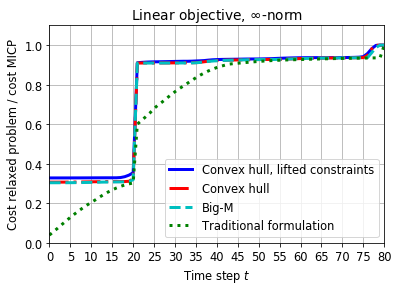

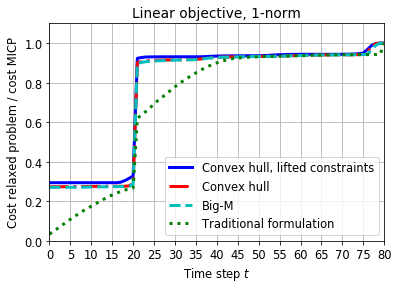

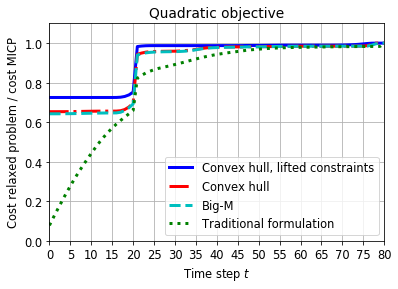

In [34]:
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = ['b', 'r', 'c','g']
linestyles = ['-', '-.', '--', ':']
plt.rc('font', size=11.5)
for norm in norms:
    for i, method in enumerate(methods):
        plt.plot(
            range(N+1),
            costs[norm][method],
            label=method,
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=3
        )
    plt.xlim((0, N))
    plt.ylim((0, 1.1))
    plt.legend()
    plt.grid(True)
    if norm == 'inf':
        plt.title(r'Linear objective, $\infty$-norm')
    elif norm == 'one':
        plt.title(r'Linear objective, 1-norm')
    elif norm == 'two':
        plt.title(r'Quadratic objective')
    plt.xticks(np.linspace(0, N, 17))
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'Cost relaxed problem / cost MICP')
    plt.savefig('relaxation_ratio_1d_' + norm + '.pdf', bbox_inches='tight')
    plt.show()

# Objective as a function of the initial state ($x_1$ and $x_3$ only)

In [ ]:
# samples for the initial position and velocity of the ball
q_p = 0.
n_levels = 10
n_samples = 101
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)

In [ ]:
# utils for the plots

def my_round(x):
    return floor(x*10.)/10.

def get_neighbors(M, i, j):
    return [
        M[i+1, j-1],
        M[i+1,   j],
        M[i+1, j+1],
        M[  i, j+1],
        M[i-1, j+1],
        M[i-1,   j],
        M[i-1, j-1],
        M[  i, j-1]
    ]

def fill_holes_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            if np.isnan(cost_mat[i,j]):
                neighbors = get_neighbors(cost_mat, i, j)
                if not any([np.isnan(n) for n in neighbors]):
                    print 'Filled', (i,j) 
                    cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

def regularize_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            neighbors = get_neighbors(cost_mat, i, j)
            if all([cost_mat[i,j] > n for n in neighbors]):
                print 'Regularized', (i,j) 
                cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

In [ ]:
# solve relaxations for all MI formulations
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    
    # get feasible sets (uses the feasible set of the CH method for the CHLC method)
    if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
        cs = get_constraint_set(controller.prog)
        var_indices = {v: i for i, v in enumerate(controller.prog.getVars())}
        v_index = var_indices[controller.prog.getVarByName('x0[1]')]
        A_sect = cs.A[:, [i for i in range(cs.A.shape[1]) if i != v_index]]
        b_sect = cs.b - cs.A[:, v_index]*q_p
        cs_sect = Polyhedron(A_sect, b_sect)
        sect = convex_hull_method_fast(cs_sect, [0,1])
        
    # samples on the grid
    cost_mat = np.empty([n_samples]*2)
    for i, q_b in enumerate(q_b_samples):
        for j, v_b in enumerate(v_b_samples):
            print(str(i) + ',' + str(j) + '   \r'),
            x0 = np.array([q_b,q_p,v_b])
            cost = controller.feedforward_relaxation(x0, [])[3]
            cost_mat[i,j] = cost
    
#     # save data
#     np.save(method + '_feasible_set_A', sect.A)
#     np.save(method + '_feasible_set_b', sect.b)
#     np.save(method, cost_mat)

In [ ]:
# plot cost and feasible set
plt.rc('font', size=14)
for method in methods:
#     cost_mat = np.load(method + '.npy')
#     if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
#         A = np.load(method + '_feasible_set_A.npy')
#         b = np.load(method + '_feasible_set_b.npy')
#         sect = Polyhedron(A, b)
    levels = [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
    cp = plt.contour(Q_b, V_b, cost_mat.T, levels=levels, cmap='viridis_r')
    plt.colorbar(cp, label='Cost relaxed problem')
    sect.plot(facecolor='w')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_3$')
    plt.title(method)
    plt.grid(True)
#     plt.savefig(method + '.pdf',bbox_inches='tight')
    plt.savefig('new_ch.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
# solve MICP on the grid (COMMENT prog.reset() BEFORE RUNNING THIS!!!)
cost_mat = np.empty([n_samples]*2)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Big-M')
controller.prog.setParam('OutputFlag', 0)
controller.prog.setParam('MIPGap', 0.01)
controller.prog.setParam('TimeLimit', 1200.)
time_limits = 0
for i, q_b in enumerate(q_b_samples):
    for j, v_b in enumerate(v_b_samples):
        print(str(i) + ',' + str(j) + ',' + str(time_limits) + '    \r'),
        x0 = np.array([[q_b],[q_p],[v_b]])
        cost = controller.feedforward(x0)[3]
        cost_mat[i,j] = cost
        if controller.prog.status == 9:
            time_limits += 1
            
# # save data
# np.save('q_b_samples', q_b_samples)
# np.save('v_b_samples', v_b_samples)
# np.save('cost_mat_miqp', cost_mat)

In [ ]:
# plot cost MICP
plt.rc('font', size=14)
cost_mat = np.load('cost_mat_miqp.npy')
cost_mat = fill_holes_cost_mat(cost_mat)
cost_mat = regularize_cost_mat(cost_mat)
n_levels = 9
levels = [0.] + [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
cp = plt.contourf(Q_b, V_b, cost_mat.T, levels=levels, cmap='viridis_r')
plt.grid(True)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.colorbar(cp, label='Cost MICP')
plt.grid(True)
# plt.savefig('cost_mat_miqp.pdf',bbox_inches='tight')
plt.show()

# Plot optimal mode sequence

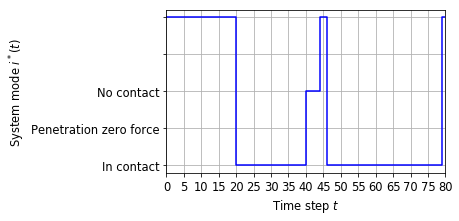

In [40]:
from copy import copy
ms = [solution['two']['Big-M']['ms'][0]] + solution['two']['Big-M']['ms']
ms_map = {0: 2, 1: 1, 2: 0}
ms_legend = [
    '',
    'In contact',
    'Penetration zero force',
    'No contact'
]
plt.figure(figsize=(5,3))
plt.step(range(N+1), [ms_map[m] for m in ms], color='b')
plt.xticks(np.linspace(0, N, 17))
plt.xlim(0, N)
# plt.ylim(0, S.nm-1)
plt.grid(True)
plt.xlabel(r'Time step $t$')
plt.ylabel(r'System mode $i^*(t)$')
plt.gca().set_yticklabels(ms_legend)
plt.savefig('mode_sequence_2d.pdf',bbox_inches='tight')